In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Overview

1、数据预处理

2、CNN建模和评估

3、预测结果+提交

# 导入库

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


# 数据预处理

In [3]:
train = pd.read_csv('/Users/admin/Desktop/Kaggle_data/mnist/train.csv')

In [4]:
test = pd.read_csv('/Users/admin/Desktop/Kaggle_data/mnist/test.csv')

## sns统计每种标签数量

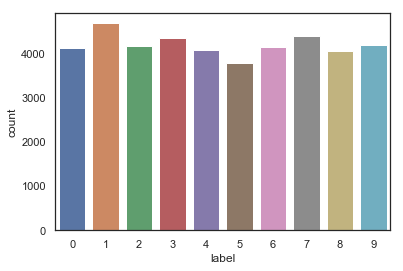

In [5]:
Y_train = train['label']

X_train = train.drop(['label'], axis=1)

del train

g = sns.countplot(Y_train)

## 4C—完整性

In [6]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## 标准化

In [8]:
X_train = X_train / 255.0
test = test/255.0

## 『image』Reshape

【图像特征reshape】4维数组：数量、横轴、纵轴、channels

In [9]:
X_train = X_train.values.reshape(-1, 28, 28, 1)

In [10]:
test = test.values.reshape(-1, 28, 28, 1)

## 4C—转换性—label encoding

In [11]:
Y_train = to_categorical(Y_train, num_classes=10)

# 数据集划分

In [12]:
random_seed = 2

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, 
                                                 test_size=0.1, random_state=random_seed)

## 「image」输出图片

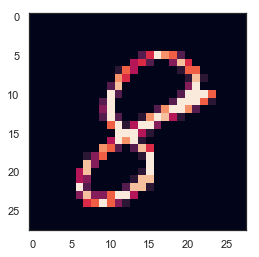

In [13]:
g = plt.imshow(X_train[0][:,:,0])

# CNN model

1、Conv2D层 => 图像的转化 => 减少参数

2、Maxpooling池化层 => 降维过滤器 => 作用：减少计算复杂度+减少过拟合

3、Dropout层 => 正则化方法 => 随机忽视一些结点 => 作用：减少过拟合

4、Relu激活函数（中间结点） + softmax（最终分类）

5、Flatten layer => 转换特征图到1维的向量

6、全连接层：Dense

Arch: [Conv2D/relu -> Conv2D/relu -> Maxpool2D -> Dopout] * 2 -> Faltten -> Dense -> 

Dropout -> Out

## 模型架构

In [14]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', 
                 activation='relu', input_shape = (28, 28, 1) ))

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))

In [15]:
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', 
                 activation='relu', input_shape = (28, 28, 1) ))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Dropout(0.25))

In [16]:
model.add(Flatten())

In [17]:
model.add(Dense(256, activation='relu'))

In [18]:
model.add(Dropout(0.5))

In [19]:
model.add(Dense(10, activation='softmax'))

## 优化器 + 损失 + 评估指标

In [20]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [21]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## 🌲『快速收敛』annealing method 退火方法

In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1,
                                            factor=0.5, min_lr=0.00001)

In [23]:
epochs=5
batch_size=86

# 🌲数据集 => 数据增强 Data augmentation

目的：


技巧：


结果：

In [24]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

# 训练模型，拟合

In [25]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/5
 - 198s - loss: 0.4203 - acc: 0.8637 - val_loss: 0.0727 - val_acc: 0.9790
Epoch 2/5
 - 153s - loss: 0.1295 - acc: 0.9617 - val_loss: 0.0425 - val_acc: 0.9881
Epoch 3/5
 - 153s - loss: 0.0949 - acc: 0.9714 - val_loss: 0.0330 - val_acc: 0.9912
Epoch 4/5
 - 154s - loss: 0.0811 - acc: 0.9761 - val_loss: 0.0362 - val_acc: 0.9898
Epoch 5/5
 - 153s - loss: 0.0729 - acc: 0.9781 - val_loss: 0.0326 - val_acc: 0.9933


# 模型评估

## 训练和测试曲线

In [42]:
history.history['val_loss']

[0.07270162285638175,
 0.04251237820922619,
 0.03303992559867246,
 0.03621046427523695,
 0.0325617210189358]

横轴：迭代次数

随着迭代次数增多，训练损失和测试损失均不断减小，且趋近相同

> 验证准确度大于训练准确度：

> 训练集中存在较多容易混淆的图片，导致训练集整体准确率较低

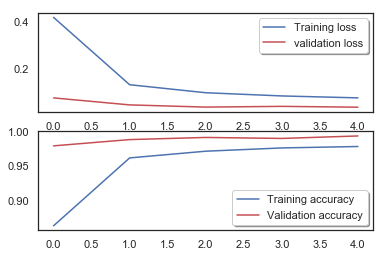

In [26]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
`
ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

##  混淆矩阵

目的：解释误分类的情况 —— 哪个类别容易被误分类成哪几种类别

In [44]:
Y_pred = model.predict(X_val)

In [45]:
Y_pred_class = np.argmax(Y_pred, axis=1)

In [46]:
Y_true = np.argmax(Y_val, axis=1)

In [47]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_class)

In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

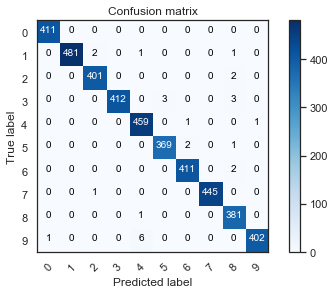

In [55]:
plot_confusion_matrix(confusion_mtx, classes=range(10))

## 进一步探究预测错误的图片

目的：解释误分类的情况 —— 误分类的图片有哪些，这些图片对应的预测类别和正确类别分别是什么？

In [58]:
errors = (Y_pred_class - Y_true !=0)

In [61]:
Y_pred_classes_errors = Y_pred_class[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

In [63]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

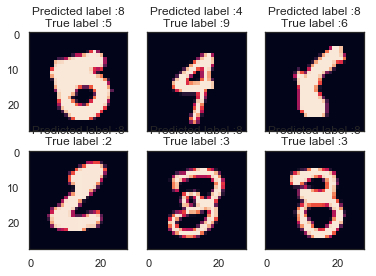

In [64]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

# 预测

In [27]:
results = model.predict(test)

In [28]:
results

array([[1.25328206e-14, 1.69472867e-12, 1.00000000e+00, ...,
        3.72805520e-09, 4.36439600e-12, 9.22717289e-15],
       [9.99997139e-01, 7.67150510e-11, 1.61521818e-08, ...,
        6.98757763e-09, 4.94736305e-08, 2.43753948e-06],
       [7.38518136e-11, 1.06666564e-10, 2.10796571e-08, ...,
        2.43290003e-07, 7.54412986e-06, 9.99988437e-01],
       ...,
       [2.70637904e-18, 1.89910758e-15, 6.78534702e-13, ...,
        1.49611416e-13, 2.83102031e-09, 3.08127052e-10],
       [1.25553179e-09, 3.33792105e-09, 9.47844914e-09, ...,
        9.96628114e-06, 1.59950829e-07, 9.99963760e-01],
       [8.59142384e-15, 8.94977180e-14, 1.00000000e+00, ...,
        2.17648677e-11, 2.39016602e-11, 9.64295130e-16]], dtype=float32)

In [29]:
labels = np.argmax(results, axis=1)

In [30]:
labels

array([2, 0, 9, ..., 3, 9, 2])

In [31]:
submission = pd.DataFrame({'ImageId':range(1,28001), 'Label':labels}, index=range(1,28001))

In [32]:
submission.to_csv('cnn_mnist_datagen.csv', index=False)

# 总结

## 为什么使用这样的网络结构

1、数据集图像决定复杂度：

> 图像由小尺寸的数字图像组成 + 图像比较标准化 => 问题简单、不需要非常深的网络结构

> Conv + relu + maxpool => 降低过拟合，可以指数级增加过滤器的数量

2、更多尝试：

> 根据实际任务选择合适的网络架构：最新论文/ImageNet => LeNet、AlexNet

> There are many Convolution neural networks models proposed in many papers . Every model gives better accuracy than the one before it . that is Alex net performs better than lenet and googLeNet is better than AlexNet but in general with some error analysis and trials you should find the number of layers and the architecture that will fit the task

> You may try to find a paper or an algorithm that was proven to work well for similar tasks. you then try to modify it to fit your task according to the results you get from the algorithm. You may also consider not to reinvent the wheel by implementing the algorithm from scratch, Instead you may use one of well known algorithm used in ImageNet or other challenges like VGG-16 , VGG-19 or yolo depending on the Task. Transfer learning makes it easier for the training process as the algorithm will be pre-trained but you will have to decide how many layers you want to freeze according to the training data you have.



## 【亮点🦍】：数据增强 => 减少过拟合

##  解释性

1、混淆矩阵

seaborn绘制混淆矩阵： https://seaborn.pydata.org/generated/seaborn.heatmap.html